# Loading the needed libraries.

In [34]:
import pandas as pd
from pandas_profiling import ProfileReport
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score, calinski_harabasz_score

from collections import Counter

from sklearn.cluster import KMeans, DBSCAN

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid

# Loading the data and EDA

https://www.dbs.ifi.lmu.de/research/outlier-evaluation/input/ALOI.tar.gz

Setting needed paths 

In [10]:
HW7_path=os.getcwd()

data_path=HW7_path+"\\Dataset"

Default structure of datafile wasn't handy so I added row with names of attributes

In [11]:
ALOI_dataset = pd.read_csv(os.path.join(data_path, 'ALOI.arff'), skiprows=32)

#numbers means indexes of attributes in original dataset
ALOI_dataset.head().T

,0,1,2,3,4
outlier,'yes','yes','yes','yes','yes'
1,0.872812,0.975206,0.963777,0.973246,0.96072
2,4.52112e-06,0,0,0,0
3,0,0,0,0,0
4,3.6169e-05,0.000651042,0.00200512,0.000556098,0.000655563
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0


Showing feature distributions (with their types), descriptive statistics and correlation coefficients 

In [0]:
ProfileReport(ALOI_dataset)

Number of variables,29
Number of observations,50000
Total Missing (%),0.0%
Total size in memory,11.1 MiB
Average record size in memory,232.0 B
Numeric,28
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


1. There are no missing points in dataset
2. There are no features with little amount of values (for example, 0 and 1), so we can claim that all features are numerical (excepting "outlier")
3. Almost all the features are not normally distributed, so it makes sense to use Spearman correlation coefficient instead of Pearson coefficient

Let's plot scatter matrix with pairs of features with biggest Spearman correlation coefficient.

In this cell rows (and columns certainly) that contains only one (correlation with itself) coefficient bigger than threshold are deleting.

Threshold is big enough because there are a lot of features and we need to weed some of them to show only the most correlated of them

In [0]:
correlation = ALOI_dataset.corr(method='spearman')

threshold = 0.75

deleted_counter = 0

#for every row
for i in reversed(range(correlation.shape[0])):

    more_than_threshold = 0

    #for every column
    for j in reversed(range(correlation.shape[1])):
        if (abs(correlation.iloc[i, j]) > threshold):
            more_than_threshold += 1

    if (more_than_threshold == 1):
        print('deleting ', i, 'row and column')
        correlation.drop(correlation.index[i], inplace=True)
        correlation.drop(correlation.columns[i], axis=1, inplace=True)

        deleted_counter += 1

print('deleted ', deleted_counter, 'features')

deleting  27 row and column
deleting  26 row and column
deleting  25 row and column
deleting  24 row and column
deleting  22 row and column
deleting  21 row and column
deleting  20 row and column
deleting  19 row and column
deleting  18 row and column
deleting  16 row and column
deleting  15 row and column
deleting  13 row and column
deleting  12 row and column
deleting  11 row and column
deleting  9 row and column
deleting  8 row and column
deleting  7 row and column
deleting  6 row and column
deleting  5 row and column
deleting  3 row and column
deleting  2 row and column
deleting  0 row and column
deleted  22 features


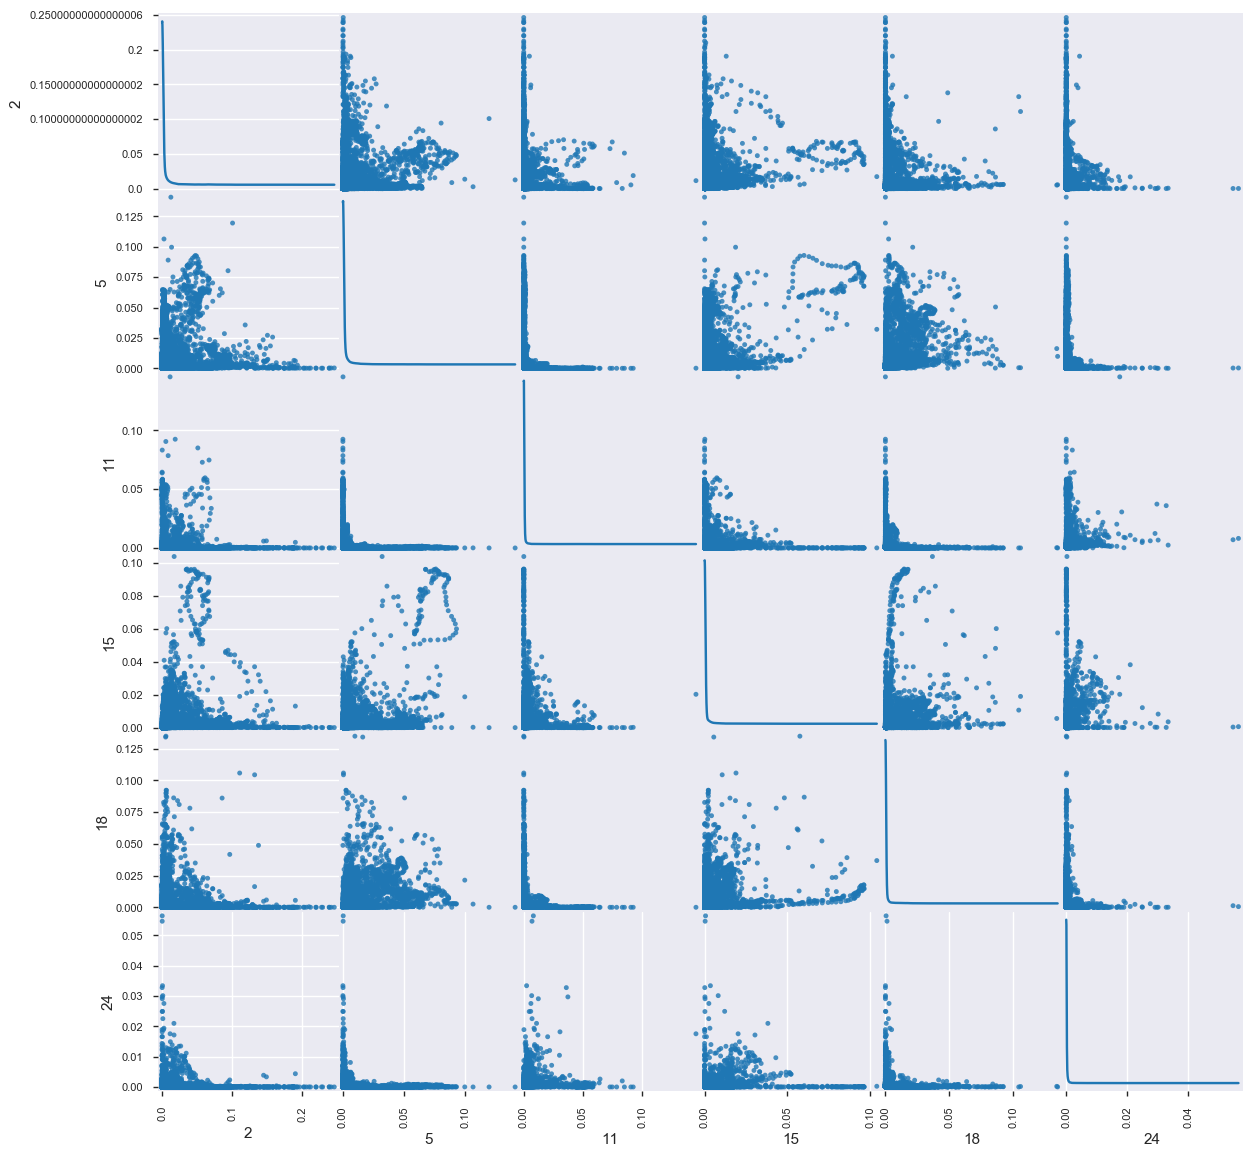

In [0]:
scatter_matrix = ALOI_dataset[correlation.index]
pd.plotting.scatter_matrix(scatter_matrix,
                           alpha=0.8,
                           figsize=(14, 14),
                           diagonal='kde',
                           s=50)
plt.show()

There are no notable dependencies

# Supervised learning

Before applying any models to our data we need to pop our target from dataset and binarize it

In [12]:
target = ALOI_dataset.pop('outlier')

target = target.replace("'yes'", 1)
target = target.replace("'no'", 0)

### Metrics

Making auxiliary functions to plot auc curves and a function that will show confus matrix, classification report and auc-roc with prc-roc

In [14]:
def show_auc_roc(test_target, pred_target):
    logit_roc_auc = roc_auc_score(test_target, pred_target)
    fpr, tpr, thresholds = roc_curve(test_target, pred_target)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.savefig('Log_ROC')
    plt.show()


def show_auc_prc(test_target, pred_target):
    precision, recall, _ = precision_recall_curve(test_target, pred_target)
    plt.figure(figsize=(5, 3))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    auc = average_precision_score(test_target, pred_target)
    plt.title(''.join(['2-class Precision-Recall curve: ', str(auc)]))

    return auc


def fit_superv_model_show_metrics(model, data, target):
    #Amount of outliers is much smaller than amount of inliers so we need to use stratified split
    train_data, test_data, train_target, test_target = train_test_split(
        data, target, test_size=0.3, random_state=17, stratify=target)
    print('train data size:', train_data.shape, '\ntrain target size:',
          train_target.shape[0], '\n')
    print('test data size:', test_data.shape, '\ntest target size:',
          test_target.shape[0], '\n\n')

    model.fit(train_data, train_target)
    pred_target = model.predict(test_data)

    confus_matrix = confusion_matrix(test_target, pred_target)
    print('confus matrix:\n', confus_matrix, '\n\n')

    clf_report = classification_report(test_target, pred_target)
    print('classification report:\n', clf_report, '\n')

    show_auc_prc(test_target, pred_target)
    show_auc_roc(test_target, pred_target)

    #return fitted model
    return model

## Logistic Regression

Testing simple Logistic Regression

train data size :  (35000, 28) 
train target size:  35000 

test data size :  (15000, 28) 
test target size:  15000 


confus matrix:
 [[14548     0]
 [  452     0]] 


classification report:
              precision    recall  f1-score   support

          0       0.97      1.00      0.98     14548
          1       0.00      0.00      0.00       452

avg / total       0.94      0.97      0.96     15000
 



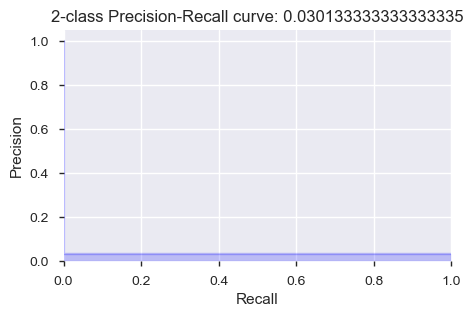

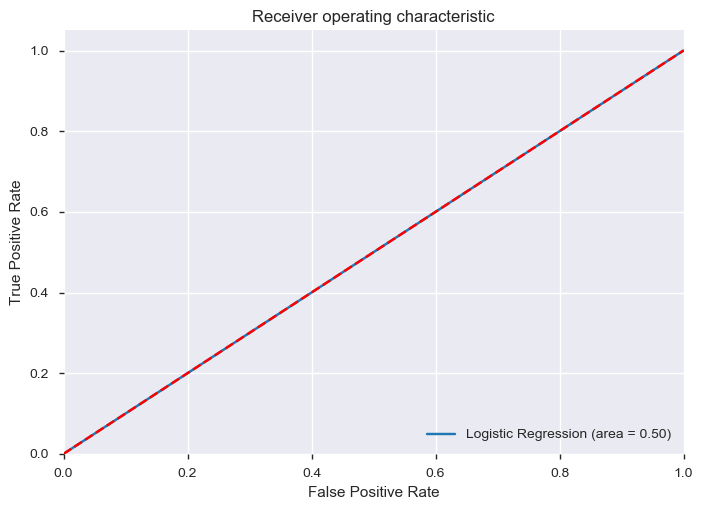

In [0]:
fit_superv_model_show_metrics(LogisticRegression(), ALOI_dataset, target);

This model categorizes all points as inliers. Let's tune the parameters

In [0]:
param_grid = dict(C=[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 
                  penalty=['l1', 'l2'])

my_scorer = make_scorer(roc_auc_score)

LR_grid = GridSearchCV(LogisticRegression(),
                       param_grid=param_grid,
                       scoring=my_scorer)

train data size :  (35000, 28) 
train target size:  35000 

test data size :  (15000, 28) 
test target size:  15000 


confus matrix:
 [[14547     1]
 [    1   451]] 


classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     14548
          1       1.00      1.00      1.00       452

avg / total       1.00      1.00      1.00     15000
 



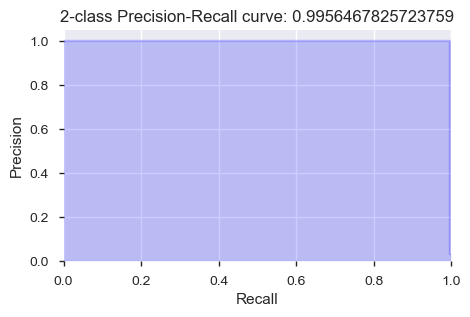

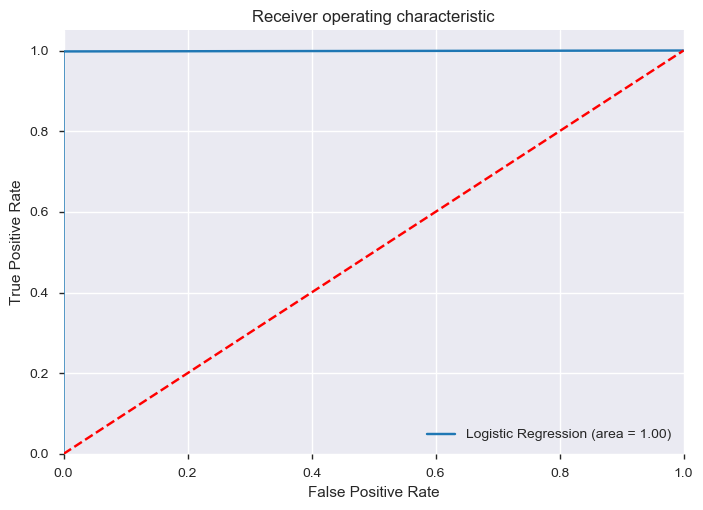

In [0]:
fit_superv_model_show_metrics(LR_grid, ALOI_dataset, target);

Tuned Logistic Regression made only 2 mistakes, so it's very good model

## K nearest neighbors

Testing simpple KNN

train data size :  (35000, 28) 
train target size:  35000 

test data size :  (15000, 28) 
test target size:  15000 


confus matrix:
 [[14548     0]
 [    0   452]] 


classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     14548
          1       1.00      1.00      1.00       452

avg / total       1.00      1.00      1.00     15000
 



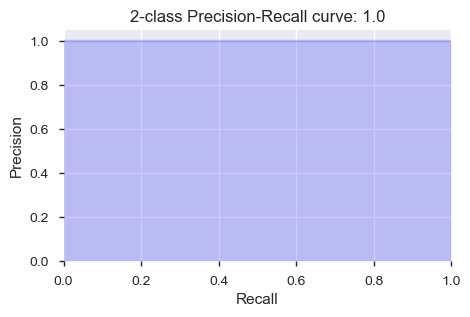

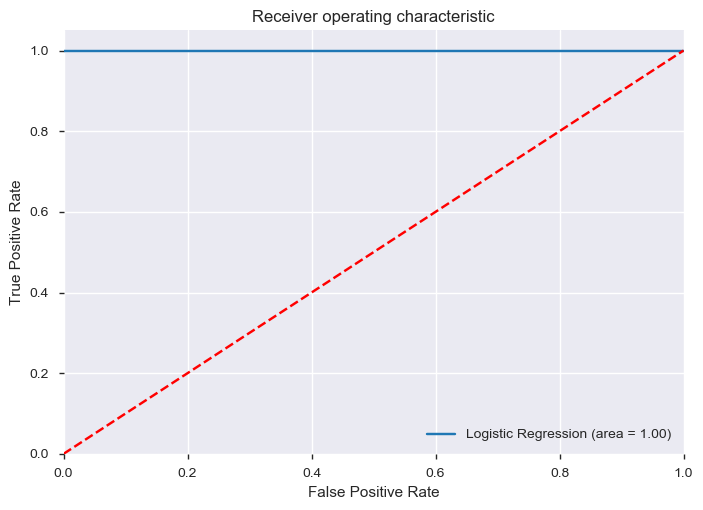

In [0]:
fit_superv_model_show_metrics(KNeighborsClassifier(), ALOI_dataset, target);

Simple KNN solved the task perfectly

#### Cross-Validation

Let's make a cross-validation to make sure that "perfect" models doesn't happen accidentally

In [0]:
train_data, test_data, train_target, test_target = train_test_split(
    ALOI_dataset, target, test_size=0.3, random_state=17, stratify=target)

modelCV = KNeighborsClassifier()

splits = [2, 3, 5, 10, 15, 30, 50]
for i in splits:
    StratKFold = StratifiedKFold(n_splits=i, random_state=42)
    results = cross_val_score(modelCV,
                              train_data,
                              train_target,
                              cv=StratKFold,
                              scoring='roc_auc')
    print(i, "- fold cross-validation roc_auc: %.3f" % (results.mean()))

2 - fold cross-validation roc_auc: 1.000
3 - fold cross-validation roc_auc: 1.000
5 - fold cross-validation roc_auc: 1.000
10 - fold cross-validation roc_auc: 1.000
15 - fold cross-validation roc_auc: 1.000
30 - fold cross-validation roc_auc: 1.000
50 - fold cross-validation roc_auc: 1.000


## SVC

Testing simpple SVC

train data size :  (35000, 28) 
train target size:  35000 

test data size :  (15000, 28) 
test target size:  15000 


confus matrix:
 [[14548     0]
 [    0   452]] 


classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     14548
          1       1.00      1.00      1.00       452

avg / total       1.00      1.00      1.00     15000
 



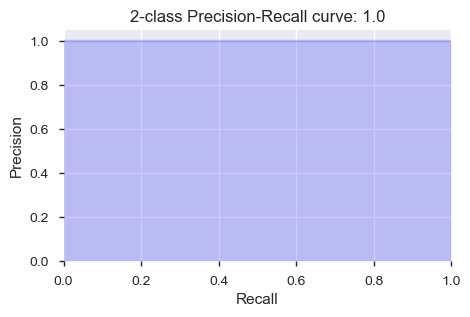

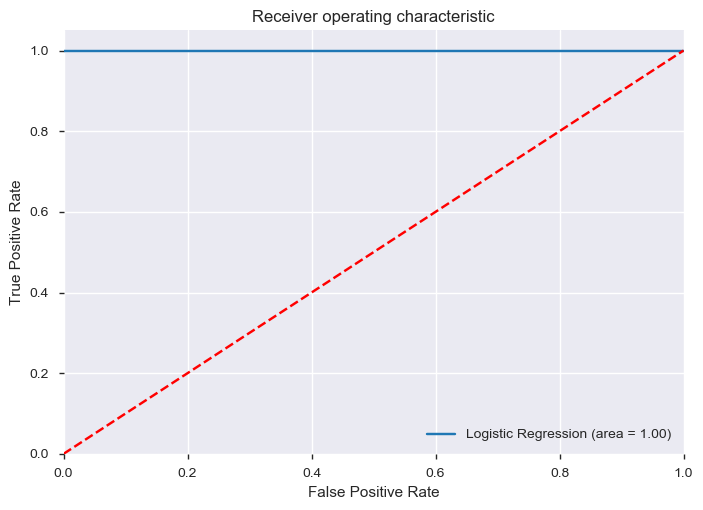

Wall time: 4min 13s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
%%time

fit_superv_model_show_metrics(SVC(), ALOI_dataset, target);

And now we don't see any mistakes. The only thing is that this algorithm takes a lot of time

## Decision tree classifier

train data size :  (35000, 28) 
train target size:  35000 

test data size :  (15000, 28) 
test target size:  15000 


confus matrix:
 [[14548     0]
 [    0   452]] 


classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14548
           1       1.00      1.00      1.00       452

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000
 



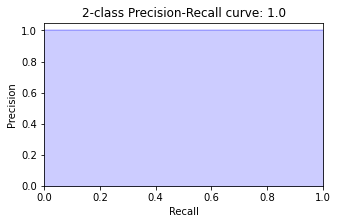

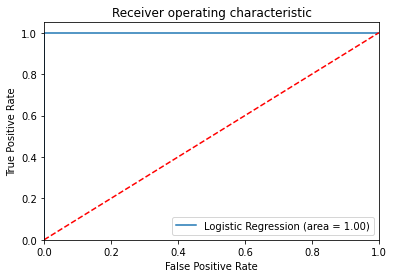

Wall time: 704 ms


In [15]:
%%time

tree_model = fit_superv_model_show_metrics(DecisionTreeClassifier(),
                                           ALOI_dataset, target)

Another one algorithm without mistakes

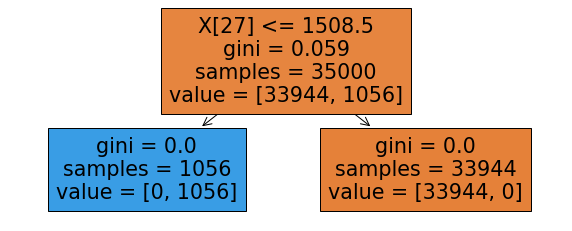

In [21]:
from sklearn import tree

# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

tree.plot_tree(tree_model, filled=True);

We see that there is a killer-feature

<AxesSubplot:>

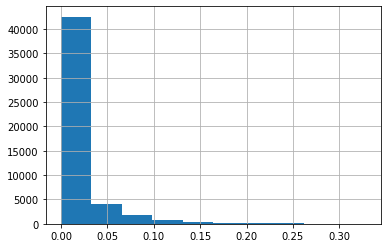

In [25]:
ALOI_dataset['27'].hist()

# Unsupervised learning

### Metrics

In [44]:
def fit_unsuperv_model_show_metrics(model, data, target):
    #Amount of outliers is much smaller than amount of inliers so we need to use stratified split
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.3, 
                                                                        random_state=42, stratify=target)
    
    print('train data size:', train_data.shape, '\ntrain target size:', train_target.shape[0], '\n') 
    print('test data size:', test_data.shape, '\ntest target size:', test_target.shape[0], '\n')  
    
    model.fit(train_data)
    
    #must have metrics
    print("ARI: %0.3f" % adjusted_rand_score(train_target, model.labels_))
    print("MI: %0.3f" % mutual_info_score(train_target, model.labels_))
    print("AMI: %0.3f" % adjusted_mutual_info_score(train_target, model.labels_))
    print("NMI: %0.3f" % normalized_mutual_info_score(train_target, model.labels_))
    try:
        print("Silhouette Coefficient: %0.3f" % silhouette_score(train_data, model.labels_, sample_size=1000))
        print("Calinski-Harabaz Index: %0.3f" % calinski_harabasz_score(train_data, model.labels_), '\n')
    except:
        print('Unable to calculate silhouette coefficient and Calinski-Harabaz index')
    
    #extra metrics
    print("Homogeneity: %0.3f" % homogeneity_score(train_target, model.labels_))
    print("Completeness: %0.3f" % completeness_score(train_target, model.labels_))
    print("V-measure: %0.3f" % v_measure_score(train_target, model.labels_))
    
    #return fitted model
    return model

## Kmeans

In [35]:
km = KMeans(n_clusters=2, max_iter=100, n_init=1)

km = fit_unsuperv_model_show_metrics(km, ALOI_dataset, target);

train data size: (35000, 28) 
train target size: 35000 

test data size: (15000, 28) 
test target size: 15000 

ARI: 0.004
MI: 0.021
AMI: 0.052
NMI: 0.052
Silhouette Coefficient: 0.618
Calinski-Harabaz Index: 105897.175 

Homogeneity: 0.159
Completeness: 0.031
V-measure: 0.052


Simple Kmeans has not good info scores (ARI, MI, AMI, NMI) that tells us that model labels are nearly random. Homogeneity, Completeness and V-measure are very little too. Silhouette coef and Calinski-Harabaz index are pretty good (but now we have nothing to compare with). 

Let's see how many labels of each cluster our model predicted

In [36]:
train_data, test_data, train_target, test_target = train_test_split(
    ALOI_dataset, target, test_size=0.3, random_state=42, stratify=target)

print('in train data inliers: {} , outliers: {}'.format(
    *dict(Counter(train_target)).values()))
print('predicted with model inliers: {} , outliers: {}'.format(
    *dict(Counter(km.labels_)).values()))

in train data inliers: 33944 , outliers: 1056
predicted with model inliers: 17435 , outliers: 17565


Our model predicts inliers and outliers with 50/50 probability, that is not good

## DBSCAN

In [45]:
dbscan = DBSCAN()

dbscan = fit_unsuperv_model_show_metrics(dbscan, ALOI_dataset, target);

train data size: (35000, 28) 
train target size: 35000 

test data size: (15000, 28) 
test target size: 15000 

ARI: 0.000
MI: 0.000
AMI: 0.000
NMI: 0.000
Unable to calculate silhouette coefficient and Calinski-Harabaz index
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000


The metrics are not promising. Let's take the tuning part from the previous HW

In [48]:
%%time

param_grid = [{
    'eps': [1e-2, 1e-1, 0.2, 0.5, 0.8, 1, 1e+1],
    'metric': ["euclidean", "manhattan"],
    'min_samples': [1, 5, 10, 50]
}]

best_score = -np.inf
best_preds = None
best_params = None

train_data, _, train_target, _ = train_test_split(ALOI_dataset,
                                                  target,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=target)

grid = ParameterGrid(param_grid)
for param_set in tqdm(grid, total=len(grid)):
    dbscan = DBSCAN(**param_set)
    dbscan_preds = dbscan.fit_predict(train_data)
    score = v_measure_score(labels_true=train_target, labels_pred=dbscan_preds)
    if score > best_score:
        best_score = score
        best_preds = dbscan_preds
        best_params = param_set

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [19:47<00:00, 21.21s/it]

Wall time: 19min 47s


In [49]:
best_score

0.05652252357819574

In [50]:
best_params

{'eps': 10.0, 'metric': 'euclidean', 'min_samples': 10}

In [52]:
fit_unsuperv_model_show_metrics(DBSCAN(**best_params), ALOI_dataset, target);

train data size: (35000, 28) 
train target size: 35000 

test data size: (15000, 28) 
test target size: 15000 

ARI: 0.002
MI: 0.116
AMI: 0.056
NMI: 0.057
Silhouette Coefficient: 0.316
Calinski-Harabaz Index: 484532.278 

Homogeneity: 0.860
Completeness: 0.029
V-measure: 0.057


Results became better

## One-class SVM

In [53]:
outliers = target[target == 1]
outliers_ratio = outliers.shape[0]/target.shape[0]

print('outliers ratio: ', outliers_ratio)

outliers ratio:  0.03016


In [ ]:
%%time

# fit the model
clf = OneClassSVM(nu=outliers_ratio, kernel="rbf", gamma=0.1)
clf.fit(train_data)
y_pred_train = clf.predict(train_data)
y_pred_test = clf.predict(test_data)

In [0]:
print('in train data inliers: {} , outliers: {}'.format(*dict(Counter(train_target)).values()))
print('predicted with model inliers: {1} , outliers: {0}\n'.format(*dict(Counter(y_pred_train)).values()))

print('in test data inliers: {1} , outliers: {0}'.format(*dict(Counter(test_target)).values()))
print('in test data inliers: {1} , outliers: {0}'.format(*dict(Counter(y_pred_test)).values()))

in train data inliers: 33944 , outliers: 1056
predicted with model inliers: 19412 , outliers: 15588

in test data inliers: 14548 , outliers: 452
in test data inliers: 4843 , outliers: 10157


In [0]:
print("accuracy: ", accuracy_score(train_target, y_pred_train))  
#print("precision: ", precision_score(train_target, y_pred_train))  
#print("recall: ", recall_score(train_target, y_pred_train))  
#print("f1: ", f1_score(train_target, y_pred_train))  
print("area under curve (auc): ", roc_auc_score(train_target, y_pred_train))  

accuracy:  0.01685714285714286
area under curve (auc):  0.5021052946385847


And now we have bad model

What if we scale our data

In [0]:
scaler = StandardScaler()

train_data_scaled=train_data.copy()
test_data_scaled=test_data.copy()

train_data_scaled = scaler.fit_transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)

In [0]:
%%time

# fit the model
clf_scaled = OneClassSVM(nu=outliers_ratio, kernel="rbf")
clf_scaled.fit(train_data_scaled)
y_pred_train_scaled = clf.predict(train_data_scaled)
y_pred_test_scaled = clf.predict(test_data_scaled)

Wall time: 1min 34s


In [0]:
Counter(y_pred_test_scaled)

Counter({-1: 15000})

In [0]:
Counter(y_pred_train_scaled)

Counter({-1: 35000})

Model think that all data is outlier